In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
# parameters
year = 0

In [3]:
target_structure_df = gpd.read_file("hex_features.geojson")
target_structure_df

,id,lon,lat,depth,disease,rest,substrate,connectivity,geometry
0,0,-16.329105,46.374396,713,0,1,B,"{'12': 0.4534674879436603, '37': 0.01291306579...","POLYGON ((-14.51711 46.60238, -15.16223 45.407..."
1,1,-16.934889,48.532510,386,1,1,B,"{'43': 0.1609716073250777, '42': 0.15078636173...","POLYGON ((-15.04778 48.77164, -15.70160 47.575..."
2,2,-17.609968,50.682301,660,1,0,A,"{'43': 0.017293166777827714, '50': 0.003760709...","POLYGON ((-15.63984 50.93390, -16.30159 49.735..."
3,3,-13.378738,45.614808,13,1,1,C,"{'45': 0.05098951544942595, '55': 0.0358501055...","POLYGON ((-11.58371 45.79082, -12.28392 44.613..."
4,4,-13.845476,47.792431,175,1,0,C,"{'46': 0.045992713382386224, '37': 0.009745769...","POLYGON ((-11.97583 47.97692, -12.69172 46.798..."
...,...,...,...,...,...,...,...,...,...
61,61,7.647046,55.683753,437,0,0,B,"{'40': 0.002349087836810961, '58': 0.018549319...","POLYGON ((9.86175 55.48030, 8.45421 54.50344, ..."
62,62,8.252435,57.853770,280,0,1,C,"{'19': 0.029002563024507117, '22': 0.075418902...","POLYGON ((10.59258 57.63694, 9.08025 56.66938,..."
63,63,8.948081,60.020024,772,1,0,C,"{'46': 0.15081197469337265, '35': 0.1414502439...","POLYGON ((11.43088 59.78781, 9.79599 58.83068,..."
64,64,10.601600,54.286838,537,0,0,B,"{'42': 0.012655647832855978, '37': 0.505012700...","POLYGON ((12.72622 54.03230, 11.30391 53.08923..."


In [4]:
target_structure_df.iloc[0]["connectivity"]

{'12': 0.4534674879436603,
 '37': 0.012913065799323206,
 '38': 0.08640451451777566,
 '58': 0.1521742965258538,
 '50': 0.2950406352133871}

In [5]:
connectivity_ds = xr.open_dataset("2023-02-22_connectivity_matrix_hexes_with_biodata.nc").isel(year=year, drop=True)
connectivity_ds

<xarray.Dataset> Size: 561MB
Dimensions:           (hex0: 8295, hex1: 8365, corner: 7)
Coordinates:
  * hex0              (hex0) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1              (hex1) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
    lon_hex0_corners  (corner, hex0) float64 465kB ...
    lat_hex0_corners  (corner, hex0) float64 465kB ...
    lon_hex1_corners  (corner, hex1) float64 468kB ...
    lat_hex1_corners  (corner, hex1) float64 468kB ...
    lon_hex0          (hex0) float64 66kB ...
    lon_hex1          (hex1) float64 67kB ...
    lat_hex0          (hex0) float64 66kB ...
    lat_hex1          (hex1) float64 67kB ...
Dimensions without coordinates: corner
Data variables:
    aqc_count_hex0    (hex0) float64 66kB ...
    rst_count_hex0    (hex0) float64 66kB ...
    pop_count_hex0    (hex0) float64 66kB ...
    dss_count_hex0    (hex0) float64 66kB ...
    aqc_count_hex1    (hex1) float64 67kB ...
    rst_count_hex1    (hex1) float64 67kB ...
    pop_count_hex1    (hex1) float64 67kB ...
    dss_count_hex1    (hex1) float64 67kB ...
    obs               (hex0, hex1) float64 555MB ...

In [6]:
all_hexes = sorted(set(connectivity_ds.hex0.data).union(set(connectivity_ds.hex1.data)))
all_hexes = [h for h in all_hexes if '-9223372036854775808' not in h]
hexes_id_mapping = {n: str(h) for n, h in enumerate(all_hexes)}
hexes_id_mapping_inv = {v: k for k, v in hexes_id_mapping.items()}

In [7]:
hexes_id_mapping

{0: '(-1, -19, 20)',
 1: '(-1, -2, 3)',
 2: '(-1, -20, 21)',
 3: '(-1, -21, 22)',
 4: '(-1, -24, 25)',
 5: '(-1, -25, 26)',
 6: '(-1, -26, 27)',
 7: '(-1, -27, 28)',
 8: '(-1, -28, 29)',
 9: '(-1, -29, 30)',
 10: '(-1, -3, 4)',
 11: '(-1, -30, 31)',
 12: '(-1, -31, 32)',
 13: '(-1, -32, 33)',
 14: '(-1, -33, 34)',
 15: '(-1, -34, 35)',
 16: '(-1, -35, 36)',
 17: '(-1, -36, 37)',
 18: '(-1, -4, 5)',
 19: '(-1, -44, 45)',
 20: '(-1, -45, 46)',
 21: '(-1, -46, 47)',
 22: '(-1, -47, 48)',
 23: '(-1, -48, 49)',
 24: '(-1, -49, 50)',
 25: '(-1, -5, 6)',
 26: '(-1, -50, 51)',
 27: '(-1, -51, 52)',
 28: '(-1, -52, 53)',
 29: '(-1, -53, 54)',
 30: '(-1, -54, 55)',
 31: '(-1, -6, 7)',
 32: '(-1, -7, 8)',
 33: '(-1, 10, -9)',
 34: '(-1, 21, -20)',
 35: '(-1, 22, -21)',
 36: '(-1, 23, -22)',
 37: '(-1, 24, -23)',
 38: '(-1, 25, -24)',
 39: '(-1, 27, -26)',
 40: '(-1, 28, -27)',
 41: '(-1, 29, -28)',
 42: '(-1, 30, -29)',
 43: '(-1, 31, -30)',
 44: '(-1, 32, -31)',
 45: '(-1, 33, -32)',
 46: '(-1, 

In [8]:
hex_polys = {
    str(hexid): Polygon(
        list(zip(
            connectivity_ds.lon_hex0_corners.sel(hex0=hexid).isel(corner=slice(None, 6)).data,
            connectivity_ds.lat_hex0_corners.sel(hex0=hexid).isel(corner=slice(None, 6)).data,
        ))
    )
    for hexid in connectivity_ds.hex0.data
    if ~connectivity_ds.lon_hex0_corners.sel(hex0=hexid).isel(corner=0).isnull()
}
hex_polys.update(
    {
        str(hexid): Polygon(
            list(zip(
                connectivity_ds.lon_hex1_corners.sel(hex1=hexid).isel(corner=slice(None, 6)).data,
                connectivity_ds.lat_hex1_corners.sel(hex1=hexid).isel(corner=slice(None, 6)).data,
            ))
        )
        for hexid in connectivity_ds.hex1.data
        if ~connectivity_ds.lon_hex1_corners.sel(hex1=hexid).isel(corner=0).isnull()
    }
)

In [9]:
aqc_count = {
    str(hexid): connectivity_ds.aqc_count_hex0.sel(hex0=hexid).data.tolist()
    for hexid in connectivity_ds.hex0.data
    if ~connectivity_ds.lon_hex0_corners.sel(hex0=hexid).isel(corner=0).isnull()
}
aqc_count.update({
    str(hexid): connectivity_ds.aqc_count_hex1.sel(hex1=hexid).data.tolist()
    for hexid in connectivity_ds.hex1.data
    if ~connectivity_ds.lon_hex1_corners.sel(hex1=hexid).isel(corner=0).isnull()
})

In [10]:
rst_count = {
    str(hexid): connectivity_ds.rst_count_hex0.sel(hex0=hexid).data.tolist()
    for hexid in connectivity_ds.hex0.data
    if ~connectivity_ds.lon_hex0_corners.sel(hex0=hexid).isel(corner=0).isnull()
}
rst_count.update({
    str(hexid): connectivity_ds.rst_count_hex1.sel(hex1=hexid).data.tolist()
    for hexid in connectivity_ds.hex1.data
    if ~connectivity_ds.lon_hex1_corners.sel(hex1=hexid).isel(corner=0).isnull()
})

In [11]:
dss_count = {
    str(hexid): connectivity_ds.dss_count_hex0.sel(hex0=hexid).data.tolist()
    for hexid in connectivity_ds.hex0.data
    if ~connectivity_ds.lon_hex0_corners.sel(hex0=hexid).isel(corner=0).isnull()
}
dss_count.update({
    str(hexid): connectivity_ds.dss_count_hex1.sel(hex1=hexid).data.tolist()
    for hexid in connectivity_ds.hex1.data
    if ~connectivity_ds.lon_hex1_corners.sel(hex1=hexid).isel(corner=0).isnull()
})

In [12]:
pop_count = {
    str(hexid): connectivity_ds.pop_count_hex0.sel(hex0=hexid).data.tolist()
    for hexid in connectivity_ds.hex0.data
    if ~connectivity_ds.lon_hex0_corners.sel(hex0=hexid).isel(corner=0).isnull()
}
pop_count.update({
    str(hexid): connectivity_ds.pop_count_hex1.sel(hex1=hexid).data.tolist()
    for hexid in connectivity_ds.hex1.data
    if ~connectivity_ds.lon_hex1_corners.sel(hex1=hexid).isel(corner=0).isnull()
})

In [13]:
depth = {k: -999 for k in aqc_count.keys()}
depth

{'(-1, -2, 3)': -999,
 '(-1, -20, 21)': -999,
 '(-1, -21, 22)': -999,
 '(-1, -24, 25)': -999,
 '(-1, -25, 26)': -999,
 '(-1, -26, 27)': -999,
 '(-1, -27, 28)': -999,
 '(-1, -28, 29)': -999,
 '(-1, -29, 30)': -999,
 '(-1, -3, 4)': -999,
 '(-1, -30, 31)': -999,
 '(-1, -31, 32)': -999,
 '(-1, -32, 33)': -999,
 '(-1, -33, 34)': -999,
 '(-1, -34, 35)': -999,
 '(-1, -35, 36)': -999,
 '(-1, -36, 37)': -999,
 '(-1, -4, 5)': -999,
 '(-1, -44, 45)': -999,
 '(-1, -45, 46)': -999,
 '(-1, -46, 47)': -999,
 '(-1, -47, 48)': -999,
 '(-1, -48, 49)': -999,
 '(-1, -49, 50)': -999,
 '(-1, -5, 6)': -999,
 '(-1, -50, 51)': -999,
 '(-1, -51, 52)': -999,
 '(-1, -52, 53)': -999,
 '(-1, -53, 54)': -999,
 '(-1, -54, 55)': -999,
 '(-1, -6, 7)': -999,
 '(-1, -7, 8)': -999,
 '(-1, 21, -20)': -999,
 '(-1, 22, -21)': -999,
 '(-1, 23, -22)': -999,
 '(-1, 24, -23)': -999,
 '(-1, 25, -24)': -999,
 '(-1, 27, -26)': -999,
 '(-1, 28, -27)': -999,
 '(-1, 29, -28)': -999,
 '(-1, 30, -29)': -999,
 '(-1, 31, -30)': -999,
 '(-

In [14]:
center_lons = {k: hexpoly.centroid.x for k, hexpoly in hex_polys.items() if not hexpoly.centroid.is_empty}
center_lats = {k: hexpoly.centroid.y for k, hexpoly in hex_polys.items() if not hexpoly.centroid.is_empty}

/home/fkirch/anaconda3/lib/python3.11/site-packages/shapely/constructive.py:288: RuntimeWarning: invalid value encountered in centroid
  return lib.centroid(geometry, **kwargs)


In [15]:
def get_fwd_connection_dict(hex_int=None):
    hex_label = hexes_id_mapping[hex_int]
    if hex_label not in connectivity_ds.hex0:
        return {}
    conn_fwd = connectivity_ds.obs.sel(hex0=hex_label)
    conn_fwd = conn_fwd.where(conn_fwd > 0, drop=True)
    conn_fwd_df = conn_fwd.to_dataframe().reset_index()[["hex1", "obs"]]
    conn_fwd_sum = conn_fwd_df["obs"].sum()
    conn_fwd_df = conn_fwd_df[conn_fwd_df.hex1 != '(-9223372036854775808, -9223372036854775808, 0)']
    conn_fwd_df["hex1"] = conn_fwd_df["hex1"].map(hexes_id_mapping_inv)
    conn_fwd_df = conn_fwd_df.rename(columns={"hex1": "hexint"}).set_index("hexint")
    return (conn_fwd_df / conn_fwd_sum).to_dict()["obs"]

In [16]:
target_structure_df.columns

Index(['id', 'lon', 'lat', 'depth', 'disease', 'rest', 'substrate',
       'connectivity', 'geometry'],
      dtype='object')

In [17]:
import tqdm

In [18]:
target_df = gpd.GeoDataFrame(
    data={
        "id": list(range(len(hexes_id_mapping))), 
        "lon": [center_lons[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping))],
        "lat": [center_lats[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping))],
        "depth": [depth[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping))],
        "disease": [dss_count[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping))],
        "rest": [rst_count[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping))],
        "aqc": [aqc_count[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping))],
        "pop": [pop_count[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping))],
        "connectivity": [get_fwd_connection_dict(n) for n in tqdm.tqdm(range(len(hexes_id_mapping)))],
    },
    geometry=[
        hex_polys[hexes_id_mapping[n]] for n in range(len(hexes_id_mapping)) 
    ],
)
target_df

100%|██████████| 8374/8374 [07:01<00:00, 19.86it/s]


,id,lon,lat,depth,disease,rest,aqc,pop,connectivity,geometry
0,0,-3.215782,51.464549,-999,0.0,0.0,0.0,1.0,{},"POLYGON ((-3.07193 51.46473, -3.14361 51.38680..."
1,1,-3.229353,54.110769,-999,0.0,0.0,0.0,3.0,"{1: 0.004529126971732001, 10: 0.16507886928002...","POLYGON ((-3.07645 54.11096, -3.15262 54.03309..."
2,2,-3.215043,51.308819,-999,0.0,0.0,0.0,6.0,"{2: 0.1023369797894799, 67: 0.0004355079203389...","POLYGON ((-3.07168 51.30900, -3.14312 51.23106..."
3,3,-3.214311,51.153079,-999,0.0,0.0,0.0,0.0,"{2: 0.17062314540059348, 1021: 0.0029673590504...","POLYGON ((-3.07144 51.15326, -3.14263 51.07532..."
4,4,-3.212150,50.685801,-999,0.0,0.0,0.0,5.0,"{4: 0.009509350631426402, 5: 0.060120074529018...","POLYGON ((-3.07072 50.68598, -3.14120 50.60802..."
...,...,...,...,...,...,...,...,...,...,...
8369,8369,-0.838398,55.959414,-999,0.0,0.0,0.0,0.0,"{5632: 0.01217438219115422, 5633: 0.0127754776...","POLYGON ((-0.67839 55.95655, -0.76285 55.88026..."
8370,8370,-0.829732,56.114909,-999,0.0,0.0,0.0,0.0,"{5632: 0.004929884977620753, 5633: 0.002371902...","POLYGON ((-0.66908 56.11203, -0.75391 56.03575..."
8371,8371,-0.820983,56.270403,-999,0.0,0.0,0.0,0.0,"{5647: 0.002483550509611663, 5648: 0.013485063...","POLYGON ((-0.65969 56.26751, -0.74488 56.19124..."
8372,8372,-0.812150,56.425896,-999,0.0,0.0,0.0,0.0,"{5648: 0.0023464714230421882, 5659: 0.00681632...","POLYGON ((-0.65020 56.42299, -0.73576 56.34673..."


In [19]:
target_df.to_file('hex_features_real.geojson', driver='GeoJSON')

In [20]:
target_df.columns

Index(['id', 'lon', 'lat', 'depth', 'disease', 'rest', 'aqc', 'pop',
       'connectivity', 'geometry'],
      dtype='object')

In [21]:
from matplotlib import pyplot as plt

In [22]:
def plot_conn_for_n(n=0):
    plt.plot(*target_df.iloc[n].geometry.boundary.xy, "ro-")
    for i in target_df.iloc[n].connectivity.keys():
        plt.plot(target_df.iloc[i].lon, target_df.iloc[i].lat, 'go')

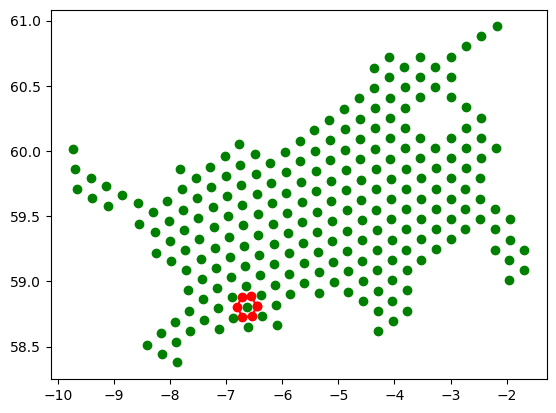

In [23]:
plot_conn_for_n(546)